In [2]:
# -*- coding: utf-8 -*-
import sys
sys.path.append('/home/jun/PersonReID')
# Set your CAM extractor
from torchcam.methods import SmoothGradCAMpp
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import scipy.io
import yaml
import math
from tqdm import tqdm
from model import * 
from utils.utils import fuse_all_conv_bn
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2
from pytorch_grad_cam.utils.image import show_cam_on_image,preprocess_image  

# Options
# --------

parser = argparse.ArgumentParser(description='Test')
parser.add_argument('--gpu_ids',default='0', type=str,help='gpu_ids: e.g. 0  0,1,2  0,2')
parser.add_argument('--which_epoch',default='last', type=str, help='0,1,2,3...or last')
parser.add_argument('--data_dir',default='/home/jun/ReID_Dataset/market1501/dataloader',type=str, help='./test_data')
parser.add_argument('--name', default='ft_ResNet50', type=str, help='save model path')
parser.add_argument('--batchsize', default=256, type=int, help='batchsize')
parser.add_argument('--linear_num', default=512, type=int, help='feature dimension: 512 or default or 0 (linear=False)')
parser.add_argument('--use_dense', action='store_true', help='use densenet121' )
parser.add_argument('--use_efficient', action='store_true', help='use efficient-b4' )
parser.add_argument('--use_hr', action='store_true', help='use hr18 net' )
parser.add_argument('--cuhk03', action='store_true', help='use PCB' )
parser.add_argument('--PCB', action='store_true', help='use PCB' )
parser.add_argument('--use_latrans', action='store_true', help='use LA_Transformer' )
parser.add_argument('--use_vit', action='store_true', help='use Vision Transformer (ViT)' )
parser.add_argument('--multi', action='store_true', help='use multiple query' )
parser.add_argument('--fp16', action='store_true', help='use fp16.' )
parser.add_argument('--ibn', action='store_true', help='use ibn.' )
parser.add_argument('--ms',default='1', type=str,help='multiple_scale: e.g. 1 1,1.1  1,1.1,1.2')

opt = parser.parse_args(['--name','ResNet50_all_trick_duke', '--which_epoch', 'last'])
###load config###
# load the training config
config_path = os.path.join('../model',opt.name,'opts.yaml')
with open(config_path, 'r') as stream:
        config = yaml.load(stream, Loader=yaml.FullLoader) # for the new pyyaml via 'conda install pyyaml'
opt.arcface = config['arcface']
opt.circle = config['circle']
opt.cosface = config['cosface']
opt.contrast = config['contrast']
opt.instance = config['instance']
opt.triplet = config['triplet']
opt.lifted = config['lifted']
opt.sphere = config['sphere']
if 'centroid' in config:      
    opt.centroid = config['centroid']        
else:
    opt.centroid = False
opt.fp16 = config['fp16'] 
opt.PCB = config['PCB']
opt.use_dense = config['use_dense']
opt.use_NAS = config['use_NAS']
opt.stride = config['stride']
if 'use_swin' in config:
    opt.use_swin = config['use_swin']
else:
    opt.use_swin = False 
if 'use_swinv2' in config:
    opt.use_swinv2 = config['use_swinv2']
else:
    opt.use_swinv2 = False
if 'use_convnext' in config:
    opt.use_convnext = config['use_convnext']
else:
    opt.use_convnext = False
if 'use_efficient' in config:
    opt.use_efficient = config['use_efficient']
else:
    opt.use_efficient = False
if 'use_hr' in config:
    opt.use_hr = config['use_hr']
else:
    opt.use_hr = False
if 'use_vit' in config:
    opt.use_vit = config['use_vit']
else:
    opt.use_vit = False
if 'use_vitraw' in config:
    opt.use_vitraw = config['use_vitraw']
else:
    opt.use_vitraw = False
if 'use_latrans' in config:
    opt.use_latrans = config['use_latrans']
else:
    opt.use_latrans = False
if 'use_latransv2' in config:
    opt.use_latransv2 = config['use_latransv2']
else:
    opt.use_latransv2 = False
if 'use_laswin' in config:
    opt.use_laswin = config['use_laswin']
else:
    opt.use_laswin = False
    
if 'use_caswin' in config:
    opt.use_caswin = config['use_caswin']
else:
    opt.use_caswin = False
    
if 'use_laswinv2' in config:
    opt.use_laswinv2 = config['use_laswinv2']
else:
    opt.use_laswinv2 = False
if 'PCB' in config:
    opt.PCB = config['PCB']
else:
    opt.PCB = False
if 'nclasses' in config: # tp compatible with old config files
    opt.nclasses = config['nclasses']
else: 
    opt.nclasses = 751 
if 'ibn' in config:
    opt.ibn = config['ibn']
if 'linear_num' in config:
    opt.linear_num = config['linear_num']
str_ids = opt.gpu_ids.split(',')
#which_epoch = opt.which_epoch
name = opt.name
if 'data_dir' in config:
    opt.data_dir = config['data_dir']

opt.data_dir = '/home/jun/ReID_Dataset/market/dataloader'
data_dir = opt.data_dir
if 'cuhk03' in config:
    opt.cuhk03 = config['cuhk03']
opt.droprate = config['droprate']
gpu_ids = []
for str_id in str_ids:
    id = int(str_id)
    if id >=0:
        gpu_ids.append(id)

print('We use the scale: %s'%opt.ms)
str_ms = opt.ms.split(',')
ms = []
for s in str_ms:
    s_f = float(s)
    ms.append(math.sqrt(s_f))

# set gpu ids
if len(gpu_ids)>0:
    torch.cuda.set_device(gpu_ids[0])
    cudnn.benchmark = True

######################################################################
# Load Data
# ---------
#
# We will use torchvision and torch.utils.data packages for loading the
# data.
#
if opt.use_swin or opt.use_vit:
    h, w = 224, 224
else:
    h, w = 256, 128
h, w = 224, 224
transform_train_list = [
        #transforms.RandomResizedCrop(size=128, scale=(0.75,1.0), ratio=(0.75,1.3333), interpolation=3), #Image.BICUBIC)
        transforms.Resize((h, w), interpolation=3),
        transforms.ToTensor(),
        ]

transform_val_list = [
        transforms.Resize(size=(h, w),interpolation=3), #Image.BICUBIC
        transforms.ToTensor(),
        ]
data_transforms = {
    'train': transforms.Compose( transform_train_list ),
    'val': transforms.Compose(transform_val_list),
}
normalize = transforms.Compose([transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 

if opt.PCB:
    transform_train_list = [
        transforms.Resize((384,192), interpolation=3),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
        ]
    transform_val_list = [
        transforms.Resize(size=(384,192),interpolation=3), #Image.BICUBIC
        transforms.ToTensor()
        ]

image_datasets = {}
image_datasets['train'] = datasets.ImageFolder(os.path.join(data_dir, 'train'),
                                          data_transforms['train'])
image_datasets['val'] = datasets.ImageFolder(os.path.join(data_dir, 'train_val/val'),
                                          data_transforms['val'])

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=opt.batchsize,
                                             shuffle=True, num_workers=2, pin_memory=True,
                                             prefetch_factor=2, persistent_workers=True) # 8 workers may work faster
              for x in ['train', 'val']}
class_names = image_datasets['val'].classes
use_gpu = torch.cuda.is_available()

######################################################################
# Load model
#---------------------------
def load_network(network):
    save_path = os.path.join('../model',name,'net_%s.pth'%opt.which_epoch)
    network.load_state_dict(torch.load(save_path))
    return network


We use the scale: 1


In [3]:
######################################################################
# Load Collected data Trained model
print('-------test-----------')
return_feature = opt.arcface or opt.cosface or opt.circle or opt.triplet or opt.contrast or opt.instance or opt.lifted or opt.sphere or opt.centroid
if opt.use_dense:
    model_structure = ft_net_dense(opt.nclasses, stride = opt.stride, linear_num=opt.linear_num)
elif opt.use_NAS:
    model_structure = ft_net_NAS(opt.nclasses, linear_num=opt.linear_num)
elif opt.use_swin:
    model_structure = ft_net_swin(opt.nclasses, linear_num=opt.linear_num)
elif opt.use_swinv2:
    model_structure = ft_net_swinv2(opt.nclasses, (h,w),  linear_num=opt.linear_num)
elif opt.use_convnext:
    model_structure = ft_net_convnext(opt.nclasses, linear_num=opt.linear_num)
elif opt.use_efficient:
    model_structure = ft_net_efficient(opt.nclasses, linear_num=opt.linear_num)
elif opt.use_hr:
    model_structure = ft_net_hr(opt.nclasses, linear_num=opt.linear_num)
elif opt.use_latrans:
    lmbd = 8
    model_structure = LATransformer(opt.nclasses, linear_num=256)
elif opt.use_vit:
    model_structure = ViTReID(opt.nclasses, linear_num=opt.linear_num)
elif opt.use_laswin:
    model_structure = LASwin(opt.nclasses, opt.droprate, opt.stride, circle = return_feature, linear_num=opt.linear_num, vertical=True)
elif opt.use_laswinv2:
    model_structure = LASwin(opt.nclasses, opt.droprate, opt.stride, circle = return_feature, linear_num=opt.linear_num, vertical=False)
elif opt.use_caswin:
    model_structure = CASwin(opt.nclasses, opt.droprate, opt.stride, circle = return_feature, linear_num=opt.linear_num)
else:
    model_structure = ft_net(opt.nclasses, stride = opt.stride, ibn = opt.ibn, linear_num=opt.linear_num)
if opt.PCB:
    model_structure = PCB(opt.nclasses)

#if opt.fp16:
#    model_structure = network_to_half(model_structure)

model = load_network(model_structure).cuda()
if opt.use_laswin:
    try:
        model.classifier = nn.Sequential()
    except:
        pass

-------test-----------


/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jun/miniconda3/envs/py311/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
from torchinfo import summary
summary(model=model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ViTReID (ViTReID)                        [32, 3, 224, 224]    [32, 702]            152,064              True
├─PatchEmbed (patch_embed)               [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (proj)                     [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Identity (norm)                   [32, 196, 768]       [32, 196, 768]       --                   --
├─Dropout (pos_drop)                     [32, 197, 768]       [32, 197, 768]       --                   --
├─Identity (patch_drop)                  [32, 197, 768]       [32, 197, 768]       --                   --
├─Identity (norm_pre)                    [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (blocks)                    [32, 197, 768]       [32, 197, 768]       --                   True
│    └─Block (0)      

In [4]:
model

ViTReID(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        

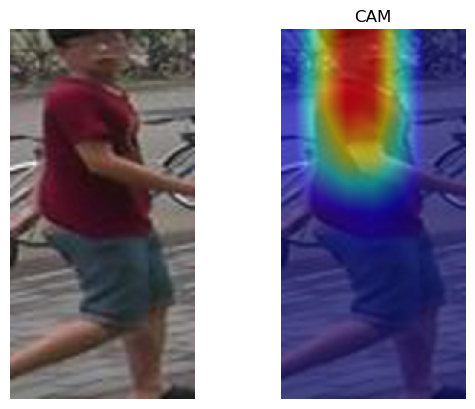

In [8]:
start = 0
limits = 1
img_dict = {}
resize = transforms.Resize((256, 128), interpolation=3)
for i, (rgb_img, label) in enumerate(image_datasets['train']):
    if i >= start and i < limits+start:
        input_tensor = normalize(rgb_img).unsqueeze(0).cuda()
        rgb_img = np.float32(rgb_img.permute(1,2,0))
        rgb_img_reshaped = resize(torch.from_numpy(rgb_img).permute(2,0,1)).permute(1,2,0)
        img_dict.update({'Original':rgb_img_reshaped}) 
        for block_id in range(12):
            if opt.use_vit:
                target_layers = [model.blocks[block_id].norm1]
                def reshape_transform(tensor, height=14, width=14):
                    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
                        height, width, tensor.size(2))
                    # Bring the channels to the first dimension,
                    # like in CNNs.
                    result = result.transpose(2, 3).transpose(1, 2)
                    return result
            elif opt.use_latrans:
                target_layers = [model.blocks[-1].norm1]
                def reshape_transform(tensor, height=14, width=14):
                    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
                        height, width, tensor.size(2))
                    # Bring the channels to the first dimension,
                    # like in CNNs.
                    result = result.transpose(2, 3).transpose(1, 2)
                    return result
            elif opt.use_swinv2 or opt.use_swin or opt.use_laswin or opt.use_laswinv2 or opt.use_caswin:
                target_layers = [model.model.layers[-1].blocks[-1].norm1]
                def reshape_transform(tensor, height=7, width=7):
                    #result = tensor.reshape(tensor.size(0),
                    #    height, width, tensor.size(2))
                    result = tensor
                    # Bring the channels to the first dimension,
                    # like in CNNs.
                    result = tensor.transpose(2, 3).transpose(1, 2)
                    return result
            elif opt.use_convnext:
                target_layers = [model.model.stages[-1].blocks[-1]]
                def reshape_transform(tensor):
                    return tensor
            elif opt.use_efficient:
                target_layers = [model.model._conv_head] 
                def reshape_transform(tensor):
                    return tensor
            elif opt.use_hr:
                target_layers = [model.model.final_layer] 
                def reshape_transform(tensor):
                    return tensor  
            elif opt.PCB:
                target_layers = [model.model.layer4[-1]]
                def reshape_transform(tensor):
                    return tensor
            elif opt.use_NAS:
                target_layers = [model.model.cell_5]
                def reshape_transform(tensor):
                    return tensor
            elif opt.use_dense:
                target_layers = [model.model.features.denseblock4]
                def reshape_transform(tensor):
                    return tensor 
            else:
                target_layers = [model.model.layer4[-1]]
                def reshape_transform(tensor):
                    return tensor
            #reshape_transform(input_tensor)
            cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)
            targets = [(ClassifierOutputTarget(label))]
            
            # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
            grayscale_cam = cam(input_tensor=input_tensor,
                                targets=targets,
                                eigen_smooth=True,
                                aug_smooth=True)
            
            # In this example grayscale_cam has only one image in the batch:
            grayscale_cam = grayscale_cam[0, :]

            visualization = resize(torch.from_numpy(show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)).permute(2,0,1)).permute(1,2,0)
            img_dict.update({f'Block [{block_id}]':visualization}) 
            #rgb_img = resize(torch.from_numpy(rgb_img).permute(2,0,1)).permute(1,2,0)
        
        #cv2.imwrite('save_path.jpg', visualization)

        fig, ax = plt.subplots(nrows = 1, ncols=2)
        rgb_img = resize(torch.from_numpy(rgb_img).permute(2,0,1)).permute(1,2,0)
        ax[0].imshow(rgb_img)
        #ax[0].set_title(f'Original')
        ax[0].margins(x=0)
        ax[0].axis(False)
        
        # Transform and plot target image
        ax[1].imshow(visualization)
        ax[1].set_title(f'CAM')
        ax[1].margins(x=0)
        ax[1].axis(False)
        
        #fig.suptitle(f'Class True: {label} | Class pred: {preds.item()}')
